<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep k-Nearest Neighbours**

Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/disseration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/disseration


Import modules

In [2]:
%tensorflow_version 2.x

## version for plotting bar labels (unstable)
# !pip install matplotlib --upgrade 

## version for the rest of plots (stable)
# !pip install matplotlib==3.1.3 

# Standard python libraries
import numpy as np
import string
import copy
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.models import load_model, Sequential
from keras.losses import MSE
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# approximate nearest neighbours libraries
!pip install pynndescent
!pip install falconn
!pip install annoy
!pip install faiss-gpu
import faiss
import pynndescent
import falconn
import annoy

In [3]:
def save_pickle(save_object, filename):
  with open(filename, 'wb') as f:
    pickle.dump(save_object, f)

def load_pickle(filename):
  with open(filename, 'rb') as f:
    loaded_object = pickle.load(f)
    return loaded_object

Import and preprocess MNIST dataset

In [4]:
# number of classes
num_classes = 10 

# input shape of images fed into CNN
input_shape = (28, 28, 1)

# import mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale to [0, 1] size
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# keep raw labels in separate array
y_test_raw = y_test[750:10000]
y_train_raw = y_train
y_cal_raw = y_test[0:750]

# convert labels to one hot enconding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split test set into calibration set
x_cal = x_test[0:750] 
y_cal = y_test[0:750]
x_test = x_test[750:10000]
y_test = y_test[750:10000]

# Model 1 - recreation of N. Papernot and P. McDaniel model 

Initialize CNN model

In [5]:
#model architechture
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding='same', activation='relu', input_shape=x_train.shape[1:]),
        layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding='valid', activation='relu'),
        layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu'),
        layers.Flatten(),
        layers.Dense(10, activation=tf.nn.softmax),
    ]
)

batch_size = 500
epochs = 8

adam_opt = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

# indexes of layers that will be indexed and used for querying nearest neibouts
neighbours_layers_indexes = [0,1,2]
knn_layers_count = len(neighbours_layers_indexes)

# number of neigbours used for Aproximate Nearest Neighbour Algorithm
K_NEIGHBOURS = 75

Train and evaluate model

In [6]:
# try loading model from files
try:
  model1 = load_model('model1_three_lay/model.h5')
  print("loaded model from disc")

# otherwise train from scratch
except OSError:
  print("failed to load model from disc")
  model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
  # model.save('deepKNN_model_new.h5')  # creates a HDF5 file
    
score = model1.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", score[1])

loaded model from disc
Test accuracy: 0.9911351203918457


# Activations

Get activations for each dataset

In [7]:
def layers_activations(model, dataset, neighbours_layers_indexes):
    reshaped_output_layer = []
    for i in neighbours_layers_indexes: # 0,1,2-convolutions layer, 5-dense layer
        layer = model.layers[i]
        lay_act = K.function([model.layers[0].input], [layer.output])([dataset])[0]
        if i != 5:
          reshaped_output_layer.append(lay_act.reshape(lay_act.shape[0], lay_act.shape[1]*lay_act.shape[2]*lay_act.shape[3]))
        else: 
          reshaped_output_layer.append(lay_act)
    
    for layer in reshaped_output_layer:
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)

    return reshaped_output_layer

def datasets_activations(model, model_adv):
  activations_train = layers_activations(model, x_train, neighbours_layers_indexes)

  activations_test = {}
  for eps in model_adv.epsilons:
    activations_test[eps] = layers_activations(model, model_adv.fgsm_adversarials[eps], neighbours_layers_indexes)

  activations_calib = layers_activations(model, x_cal, neighbours_layers_indexes)

  return activations_train, activations_test, activations_calib


# Adversarial Examples

In [8]:
## This class provides functionality for generating adversairial examples
class Adversaries:
  def __init__(self, model, epsilons, folder):
    self.model = model
    self.epsilons = copy.deepcopy(epsilons)
    self.folder = folder

    self.fgsm_adversaries = self.generate_adversaries()
    self.plot_accuracy_vs_epsilon()

  def load_adversaries(self, folder):
    adversaries = {}
    for eps in self.epsilons:
      eps_str = str(eps)
      eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
      path = folder + 'adv_datasets/adversaries' + eps_str  + '.npy'
      adversaries[eps] = np.load(path)
    return adversaries

  # function saving adversarials examples
  def save_adversaries(self, adversaries, folder):
    for eps in self.epsilons:
      eps_str = str(eps)
      eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
      filename = folder + 'adv_datasets/adversaries' + eps_str + '.npy'
      np.save(filename, adversaries[eps])
      print('saved ' + str(eps))

  def generate_single_adversary(self, image, label, eps):

    # Make images shape (1, 28, 28, 1)
    image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)

    # record our gradients
    with tf.GradientTape() as tape:

      # start tracing image by the Tape
      tape.watch(image)

      #compute prediction
      pred = self.model(image)

      # compute loss
      loss = MSE(label, pred)

      # calculate the gradient of loss function 
      grad = tape.gradient(loss, image)

      # compute the sign of the gradient
      sign = tf.sign(grad)

      # create perturbation
      perturbation = sign * eps

      # apply perturbation to image
      adversary = (image + perturbation).numpy()

      # Make images shape (28, 28, 1)
      adversary = adversary.reshape(28, 28, 1)
      
      return adversary

  def generate_adversaries(self):
    try:
      adversaries = self.load_adversaries(self.folder)
      self.epsilons.insert(0, 0.0)
      adversaries[0.0] = x_test
      print('loaded adversarial datasets from disc')
    except FileNotFoundError:
      print('failed to load adversarial datasets from disc')
      adversaries = {}
      for eps in self.epsilons:
        adv = []
        for i in range(x_test.shape[0]):
          adv.append(self.generate_single_adversary(x_test[i], y_test[i], eps))
        adversaries[eps] = np.array(adv)
        # self.save_adversaries(adversaries, folder)
      self.epsilons.insert(0, 0.0)
      adversaries[0.0] = x_test
    return adversaries

  def plot_accuracy_vs_epsilon(self):
    accuracies_plot = []
    for eps in self.epsilons:
      adversary_score = self.model.evaluate(self.fgsm_adversaries[eps], y_test, verbose=0)
      accuracies_plot.append(adversary_score[1] * 100)
      print(adversary_score)

    plt.figure(figsize=(5,5))
    plt.plot(self.epsilons, accuracies_plot, linestyle='--', marker='o', color='b', label = 'DNN')

    plt.yticks(np.arange(0, 101, step=10))
    plt.xticks(np.arange(0, 0.16, step=0.025))
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epsilon")
    plt.legend()

    plt.show()

  def plot_adv_examples(self):
    counter = 0
    plt.figure(figsize=(10,15))

    for eps in self.epsilons:
      adv_img = self.fgsm_adversaries[eps][10:15]
      true_label = y_test[10:15]

      adv_results = model1.predict(self.fgsm_adversaries[eps][10:15])
      predicted_labels = []
      for result in adv_results:
        predicted_labels.append(np.argmax(result))

      for i in range(5):
          counter += 1
          plt.subplot(len(self.epsilons), 5, counter)
          plt.xticks([], [])
          plt.yticks([], [])

          if i == 0:
            plt.ylabel('Eps: '+ str(eps), fontsize=14)

          label = np.argmax(true_label[i])
          if predicted_labels[i] != label:
            incorrect_label = plt.title('Pred. label: ' + str(predicted_labels[i]))
            plt.setp(incorrect_label, color='r')
          else:
            if eps == 0.0:
              plt.title(r"$\bf{" + 'True label:' + str(label) + "}$" + '\n\nPred. label:' + str(predicted_labels[i]))
            else:
              plt.title('Pred. label: ' + str(predicted_labels[i]))

          plt.imshow(np.squeeze(adv_img[i]), cmap="gray")
    plt.savefig('adv_examples.png')
    plt.show()

# PyNND

In [21]:
class PyNND:
  def __init__(self, model, activations_train, activations_test, activations_calib, neighbours_layers_indexes, epsilons, folder):
    self.model = model
    self.neighbours_layers_indexes = neighbours_layers_indexes
    self.activations_train = activations_train
    self.activations_test = activations_test
    self.activations_calib = activations_calib
    self.knn_layers_count = len(neighbours_layers_indexes)
    self.epsilons = epsilons
    self.folder = folder
    self.knn_eps = 0.1

    index_act = self.index_layer()
    self.neighbours = self.find_neighbours_test(index_act)
    self.neighbours_calib = self.find_neighbours_calib(index_act)

  def index_layer(self):
    try: 
        index_act = load_pickle(self.folder + 'neighbours_index_new.pkl')
        print('loaded neighbours index from disc')
    except FileNotFoundError:
        print('failed to load neighbours index from disc')
        index_act = {}
        for layer in range(self.knn_layers_count):
          index_act[layer] = pynndescent.NNDescent(self.activations_train[layer]) # index training data
          index_act[layer].prepare() # prepare for faster query
        # save_pickle(index_act, 'model1exact/neighbours_index.pkl')
    return index_act

  def query_index(self, index, activations):
    neighbours = index.query(activations, k=K_NEIGHBOURS, epsilon=self.knn_eps)
    neighbours_labels = y_train_raw[neighbours[0]]
    return neighbours_labels

  def find_neighbours_test(self, index):
    try:
      neighbours = load_pickle(self.folder + 'neighbours_new.pkl')
      print('loaded neighbours from disc')
    except FileNotFoundError:
      print('failed to load neighbours from disc')
      neighbours = {}
      for layer in range(knn_layers_count):
        neighbours[layer] = {}
        for eps in self.epsilons:
          neighbours[layer][eps] = self.query_index(index[layer], self.activations_test[eps][layer])
      # save_pickle(neighbors, 'model1exact/neighbours.pkl')
    return neighbours

  def find_neighbours_calib(self, index):
    neigbours_calib = {}
    for layer in range(self.knn_layers_count):
      neigbours_calib[layer] = self.query_index(index[layer], self.activations_calib[layer])
    return neigbours_calib

# Annoy

In [10]:
class Annoy:
  def __init__(self, model, activations_train, activations_test, activations_calib, neighbours_layers_indexes, epsilons, folder):
    self.model = model
    self.neighbours_layers_indexes = neighbours_layers_indexes
    self.activations_train = activations_train
    self.activations_test = activations_test
    self.activations_calib = activations_calib
    self.epsilons = epsilons
    self.folder = folder

    self.knn_layers_count = len(neighbours_layers_indexes)

    index_act = self.index_layer()
    self.neighbours = self.find_neighbours_test(index_act)
    self.neighbours_calib = self.find_neighbours_calib(index_act)

  def save_annoy_index(self, neighbours):
    for layer in range(self.knn_layers_count):
      neighbours[layer].save(self.folder + 'annoy/index/annoy_index_' + str(layer) + '.ann')

  def load_annoy_index(self):
    index_act = {}
    for layer in range(self.knn_layers_count):
      index_act[layer] = annoy.AnnoyIndex(self.activations_train[layer].shape[1], 'angular')
      index_act[layer].load(self.folder +'annoy/index/annoy_index_' + str(layer) + '.ann')
    return index_act

  def load_annoy_neighbours(self):
    neighbors_annoy = {}
    for layer in range(knn_layers_count):
      neighbors_annoy[layer] = load_pickle(self.folder + 'annoy/neighbours/neighbours_annoy_layer_' + str(layer + 1) + '.pkl')
      for eps in self.epsilons:
        neighbors_annoy[layer][eps] = y_train_raw[neighbors_annoy[layer][eps]]
    return neighbors_annoy
  
  def index_layer(self):
    try: 
      index_act = self.load_annoy_index()
      print('loaded annoy index successfully')
    except OSError:
      print('failed to load neighbours index from disc')
      index_act = {}
      for layer in range(self.knn_layers_count):
        index_act[layer] = annoy.AnnoyIndex(self.activations_train[layer].shape[1], 'angular')

      for layer in range(self.knn_layers_count):
        for i in range(self.activations_train[layer].shape[0]):
          index_act[layer].add_item(i, self.activations_train[layer][i])
        index_act[layer].build(50) # build 50 trees

      # self.save_annoy_index(index_act)
    return index_act

  def find_neighbours_test(self, index):
    try:
      neighbours = self.load_annoy_neighbours()
      print('loaded annoy neighbours')
    except OSError:
      print('failed to loaded annoy neighbours')
      neighbours = {}
      for layer in range(self.knn_layers_count):
        neighbours[layer] = {}
        for eps in self.epsilons:
          arr = []
          for act in self.activations_test[eps][layer]:
            indexes = index[layer].get_nns_by_vector(act, K_NEIGHBOURS)
            arr.append(y_train_raw[indexes])
          neighbours[layer][eps] = np.array(arr)
    return neighbours

  def find_neighbours_calib(self, index):
    neigbours_cal = {}
    for layer in range(self.knn_layers_count):
      arr = []
      for act in self.activations_calib[layer]:
        calib_indexes = index[layer].get_nns_by_vector(act, K_NEIGHBOURS)
        arr.append(y_train_raw[calib_indexes])
      neigbours_cal[layer] = np.array(arr)
    return neigbours_cal

# Falconn

In [17]:
class Falconn:
  def __init__(self, model, activations_train, activations_test, activations_calib, neighbours_layers_indexes, epsilons, folder):
    self.model = model
    self.neighbours_layers_indexes = neighbours_layers_indexes
    self.activations_train = activations_train
    self.activations_test = activations_test
    self.activations_calib = activations_calib
    self.epsilons = epsilons
    self.folder = folder
    self.knn_layers_count = len(neighbours_layers_indexes)
    self.number_of_tables = 50

    index_act, center_arr = self.index_layers()
    print('finished indexing')

    self.neighbours = self.find_neighbours_test(index_act, center_arr)
    self.neighbours_calib = self.find_neighbours_calib(index_act)

  def index_single_layer(self, act, center):
    # act -= center
    params_cp = falconn.LSHConstructionParameters()
    params_cp.dimension = len(act[0])
    params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
    params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
    params_cp.l = self.number_of_tables
    params_cp.num_rotations = 1
    params_cp.seed = 5721840
    params_cp.num_setup_threads = 0
    params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
    falconn.compute_number_of_hash_functions(18, params_cp)
    table = falconn.LSHIndex(params_cp)
    table.setup(act - center) #changed
    query_object = table.construct_query_object()

    return query_object

  def index_layers(self):
    index_act = {}
    center_arr = []
    for layer in range(self.knn_layers_count):
      center = np.mean(self.activations_train[layer], axis=0)
      center_arr.append(center)
      index_act[layer] = self.index_single_layer(self.activations_train[layer], center)
    return index_act, center_arr

  def query_index(self, index, activations, center):
    # activations -= center
    closest_labels = []

    for (j, query) in enumerate(activations - center): # changed
        a = index.find_k_nearest_neighbors(query, 75)
        y_label = y_train[a]
        y_label_2 = []
        for i in range(y_label.shape[0]):
            y_label_2.append(np.argmax(y_label[i]))
        closest_labels.append(y_label_2)
    return np.array(closest_labels)

  def find_neighbours_test(self, index, center_arr):
    try:
      neighbours = load_pickle(self.folder + 'lsh/neighbours_lsh_new.pkl')
      print('loaded neighbours from disc')
    except FileNotFoundError:
      print('failed to load neighbours index from disc')
      neighbours = {}
      for layer in range(self.knn_layers_count):
        neighbours[layer] = {}
        for eps in self.epsilons:
          neighbours[layer][eps] = self.query_index(index[layer], self.activations_test[eps][layer], center_arr[layer])
    return neighbours

  def find_neighbours_calib(self, index):
    neigbours_cal = {}
    for layer in range(self.knn_layers_count):
      center = np.mean(self.activations_calib[layer], axis=0)
      neigbours_cal[layer] = self.query_index(index[layer], self.activations_calib[layer], center)

    return neigbours_cal

# DkNN

In [12]:
class DkNN:
  def __init__(self, ann_object):
    self.model = ann_object.model
    self.neighbours = ann_object.neighbours
    self.neighbours_calib = ann_object.neighbours_calib
    self.knn_layers_count = ann_object.knn_layers_count
    self.epsilons = ann_object.epsilons

    nonconformity_calib = self.calibrate_nonconformity()
    p_values, knn_predicted_labels = self.calculate_performance_parameters(nonconformity_calib)

    for eps in self.epsilons:
      self.plot_reliability('DkNN', eps, p_values[eps], knn_predicted_labels[eps])

  # Returns how many neighbours does not match real label
  def count_not_matching_labels(self, neihgbours_arr):
    nonconformity = []
    for i in range(0, neihgbours_arr.shape[0]):
      incorrect = np.sum(neihgbours_arr[i] != y_cal_raw[i])
      nonconformity.append(incorrect)

    return np.array(nonconformity)

  def calibrate_nonconformity(self):
    nonconformity_calib = np.zeros(self.neighbours_calib[0].shape[0])
    for layer in range(self.knn_layers_count):
      nonconformity_calib += self.count_not_matching_labels(self.neighbours_calib[layer])

    # sort
    nonconformity_calib =  np.sort(nonconformity_calib)
    # trim zeros
    nonconformity_calib = np.trim_zeros(nonconformity_calib, trim='f')

    return nonconformity_calib

  # calculate_nonconformity for each class based on calibration
  def calculate_nonconformity(self, eps):
    nonconformity_for_class = np.full((x_test.shape[0], num_classes), K_NEIGHBOURS * self.knn_layers_count, dtype=np.float32)
    for i in range(x_test.shape[0]):
      for layer in range(self.knn_layers_count):
        for neighbour in self.neighbours[layer][eps][i]:
          nonconformity_for_class[i][neighbour] -= 1

    return nonconformity_for_class

  def calculate_p_values(self, nonconformity_for_class, nonconformity):
    p_values = np.empty((x_test.shape[0], num_classes),  dtype=np.float32)
    for i in range(x_test.shape[0]):
      for j in range(num_classes):
        insert_index = bisect_left(nonconformity, nonconformity_for_class[i][j])
        p_values[i][j] = (nonconformity.shape[0] - insert_index) / nonconformity.shape[0]
    return p_values

  def predict_labels(self, nonconformity_for_class):
    knn_predicted_labels = []
    for i in range(x_test.shape[0]):
      knn_predicted_labels.append(np.argmin(nonconformity_for_class[i]))
    return np.array(knn_predicted_labels)

  def calculate_performance_parameters(self, nonconformity_calib):
    nonconformity_for_class = {}
    p_values = {}
    knn_predicted_labels = {}
    for eps in self.epsilons:
      nonconformity_for_class = self.calculate_nonconformity(eps)
      p_values[eps] = self.calculate_p_values(nonconformity_for_class, nonconformity_calib)
      knn_predicted_labels[eps] = self.predict_labels(nonconformity_for_class)
    return p_values, knn_predicted_labels

  def calculate_performance_per_cred(self, confidence, predicted_labels):
    credibility = np.max(confidence, axis=1)
    distribution = np.zeros(10)
    correct_labels = np.zeros(10)

    for i in range(credibility.shape[0]):
      bin = credibility[i] // 0.1 / 10
      bin_index = int(bin*10)
      distribution[bin_index] += 1
      if (predicted_labels[i] == y_test_raw[i]):
        correct_labels[bin_index] += 1

    for i in range(correct_labels.shape[0]):
      if correct_labels[i] != 0 and distribution[i] != 0:
        correct_labels[i] /=  distribution[i]

    return distribution, correct_labels 

  def plot_reliability(self, model_type, eps, confidence, predicted_labels):

    if model_type == 'Softmax':
      softmax_probabilities = model1.predict(model1adv.fgsm_adversarials[eps])
      softmax_classes = softmax_probabilities.argmax(axis=-1)
      confidence = softmax_probabilities
      num_points, reliability_diag = self.calculate_performance_per_cred(confidence, softmax_classes)
    else:
      num_points, reliability_diag = self.calculate_performance_per_cred(confidence, predicted_labels)
      print(np.array(num_points))
      print(np.array(reliability_diag))


    bars_begin = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    bars_end = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bars_center = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]


    fig, ax1 = plt.subplots()
    p1 = ax1.bar(bars_center, np.round(reliability_diag*100, 1), width=.1, alpha=0.8, edgecolor = "black")

    ax2 = ax1.twinx()
    ax2.plot(bars_center, num_points, color='r', linestyle='-', linewidth=6.0)
    ax1.set_ylim([0, 100])

    plt.title("Reliability Diagram: " + model_type + ', eps: ' + str(eps))
    ax2.set_ylabel('Number of points in dataset', color='r')
    ax1.set_xlabel('Prediction Credibility %')
    ax1.set_ylabel('Prediction Accuracy %')
    ax2.tick_params(colors='r')
    # ax1.bar_label(p1, label_type='center', fmt='%.1f%%',  weight='bold')
    
    plt.show()

In [13]:
    # def test_model_accuracy(labels1, labels2):
#   correct_labels = np.sum(labels1 == labels2)
#   return correct_labels / labels1.shape[0] * 100

# def accuracy_per_model(knn_predicted_labels):
#   accuracies_plot_knn = []
#   for eps in epsilons:
#     model_accuracy = test_model_accuracy(knn_predicted_labels[eps], y_test_raw)
#     accuracies_plot_knn.append(model_accuracy)
#   return accuracies_plot_knn

# accuracies_plot_knn = accuracy_per_model(knn_predicted_labels)
# plot_accuracy_vs_epsilon(model, fgsm_adversarials)
# plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN - NND')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

# Test

loaded adversarial datasets from disc
[0.031924787908792496, 0.9911351203918457]
[5.933675289154053, 0.12551350891590118]


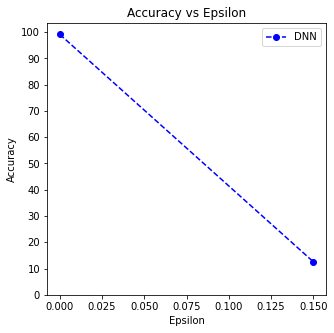

In [14]:
model1adv = Adversaries(
    model = model1,
    epsilons = [0.15],
    folder = 'model1_three_lay/')

activations_train_m1, activations_test_m1, activations_calib_m1 = datasets_activations(model1, model1adv)

finished indexing
loaded neighbours from disc


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[ 295.  408.  432.  321.  318.  279.  503.  437.  361. 5896.]
[0.78644068 0.87990196 0.96990741 0.97819315 0.99371069 0.98924731
 0.99801193 1.         0.99722992 1.        ]


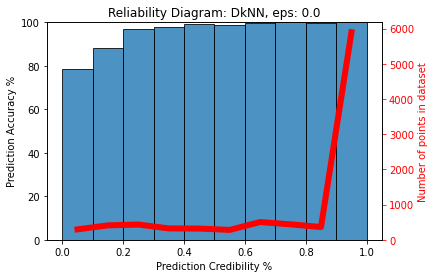

[4713. 2653.  662.  281.  165.  102.  131.   97.   63.  383.]
[0.33630384 0.59253675 0.51057402 0.55160142 0.62424242 0.76470588
 0.78625954 0.83505155 0.82539683 0.92950392]


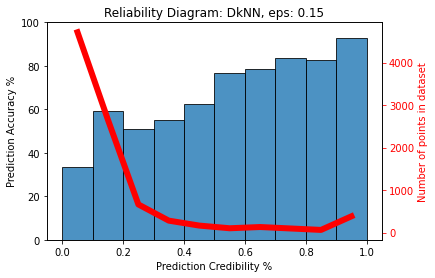

In [18]:
test1 = Falconn(
    model1,
    activations_train_m1,
    activations_test_m1,
    activations_calib_m1,
    neighbours_layers_indexes,
    model1adv.epsilons,
    'model1_three_lay/')

a1 = DkNN(test1)

loaded neighbours index from disc
loaded neighbours from disc
[ 238.  380.  417.  270.  430.  248.  201.  257.  392. 6417.]
[0.68907563 0.91315789 0.96642686 0.98888889 0.99534884 0.99193548
 0.99004975 1.         0.99744898 0.99984416]


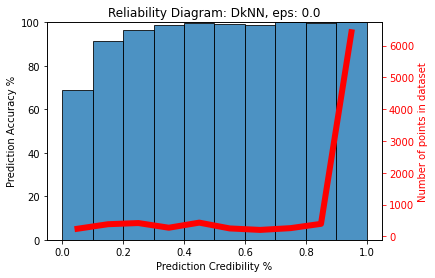

[4054. 3153.  649.  242.  197.  118.   74.   91.  103.  569.]
[0.5550074  0.66254361 0.47303544 0.53305785 0.55329949 0.66949153
 0.68918919 0.84615385 0.84466019 0.87346221]


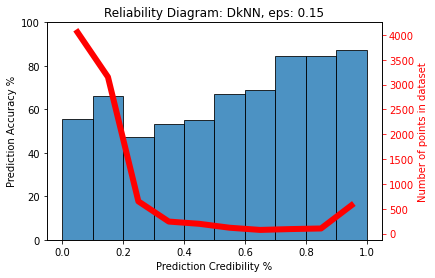

In [22]:
pynnd_m1 = PyNND(
    model1,
    activations_train_m1,
    activations_test_m1,
    activations_calib_m1,
    neighbours_layers_indexes,
    model1adv.epsilons,
    'model1_three_lay/'
    )

dknn_pynnd_m1 = DkNN(pynnd_m1)

loaded annoy index successfully
loaded annoy neighbours
[ 288.  362.  428.  313.  338.  367.  207.  273.  407. 6267.]
[0.6875     0.93370166 0.95794393 0.99041534 0.99112426 0.99455041
 0.99516908 0.996337   0.997543   1.        ]


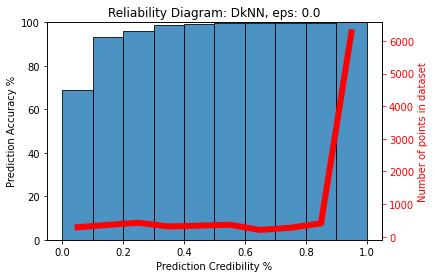

[3889. 3222.  722.  280.  177.  173.   79.   87.   93.  528.]
[0.53175624 0.66759777 0.45429363 0.525      0.50282486 0.64739884
 0.7721519  0.82758621 0.78494624 0.87689394]


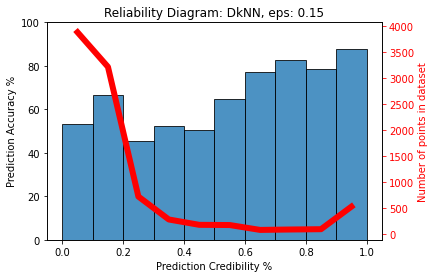

In [19]:
test3 = Annoy(
    model1,
    activations_train_m1,
    activations_test_m1,
    activations_calib_m1,
    neighbours_layers_indexes,
    model1adv.epsilons,
    'model1_three_lay/')

a3 = DkNN(test3)

# Faiss

In [ ]:
# neighbours_index_faiss = {}
# dim = activations_train[layer].shape[1]
# ind = faiss.IndexLSH(dim, dim * 2)
# for layer in range(knn_layers_count):
#   neighbours_index_faiss[layer] = faiss.IndexLSH(activations_train[layer].shape[1], dim * 4)
#   neighbours_index_faiss[layer].add(activations_train[layer])

In [ ]:
# neighbors_faiss = {}
# for layer in range(knn_layers_count):
#   neighbors_faiss[layer] = {}
#   for eps in epsilons:
#     neighbors_faiss[layer][eps] = neighbours_index_faiss[layer].search(activations[eps][layer], 75)[0]

# Nmslib

In [ ]:
# !pip install nmslib
# import nmslib

In [ ]:
# index_nmslib = nmslib.init(method='hnsw', space='cosinesimil')
# index_nmslib.addDataPointBatch(activations_train[0])
# index_nmslib.createIndex({'post': 2}, print_progress=True)
# ids, distances = index_nmslib.knnQuery(activations[0.0][0], k=75)

# Faiss 2

In [ ]:
# class IVPQIndex():
#     def __init__(self, vectors, labels):
#         self.dimension = vectors.shape[1]
#         self.vectors = vectors.astype('float32')
#         self.labels = labels    
#         def build(self, number_of_partition=8, search_in_x_partitions=2, subvector_size=8):
#           quantizer = faiss.IndexFlatL2(self.dimension)
#           self.index = faiss.IndexIVFPQ(quantizer, 
#                                         self.dimension, 
#                                         number_of_partition, 
#                                         search_in_x_partitions, 
#                                         subvector_size)
#           self.index.train(self.vectors)
#           self.index.add(self.vectors)
        
#     def query(self, vectors, k=10):
#         distances, indices = self.index.search(vectors, k) 
#         # I expect only query on one vector thus the slice
#         return [self.labels[i] for i in indices[0]]

In [ ]:
# index_quan = faiss.IndexFlatL2(activations_train[layer].shape[1])

# Falconn

In [ ]:
def LSH_index(dataset, center):
  number_of_tables = 50
  dataset -= center
  params_cp = falconn.LSHConstructionParameters()
  params_cp.dimension = len(dataset[0])
  params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
  params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
  params_cp.l = number_of_tables
  # we set one rotation, since the data is dense enough,
  # for sparse data set it to 2
  params_cp.num_rotations = 1
  params_cp.seed = 5721840
  # we want to use all the available threads to set up
  params_cp.num_setup_threads = 0
  params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
  # we build 18-bit hashes so that each table has
  # 2^18 bins; this is a good choise since 2^18 is of the same
  # order of magnitude as the number of data points
  falconn.compute_number_of_hash_functions(18, params_cp)
  table = falconn.LSHIndex(params_cp)
  table.setup(dataset)
  query_object = table.construct_query_object()

  return query_object

index_act_lsh = {}
center_arr = []
for layer in range(knn_layers_count):
  center = np.mean(activations_train[layer], axis=0)
  center_arr.append(center)
  index_act_lsh[layer] = LSH_index(activations_train[layer], center)

Neighbours LSH

In [ ]:
def LSH_fin_neighbours(query_arr, index, center):
  query_arr -= center
  closest_labels = []

  for (j, query) in enumerate(query_arr):
      a = index.find_k_nearest_neighbors(query, 75)
      y_label = y_train[a]
      y_label_2 = []
      for i in range(y_label.shape[0]):
          y_label_2.append(np.argmax(y_label[i]))
      closest_labels.append(y_label_2)
  return np.array(closest_labels)

try:
  neighbors_lsh = load_pickle(neihbours_lsh + 'lsh/neighbours_lsh_new.pkl')
  print('loaded neighbours from disc')
except FileNotFoundError:
  neighbors_lsh = {}
  for layer in range (knn_layers_count):
    neighbors_lsh[layer] = {}
    for eps in epsilons:
      neighbors_lsh[layer][eps] = LSH_fin_neighbours(activations[eps][layer], index_act_lsh[layer], center_arr[layer])
  # save_pickle(neighbors_lsh, 'neighbours_lsh_new.pkl')

Calibration LSH

In [ ]:
neigbours_calib_lsh = {}
for layer in range(knn_layers_count):
  center = np.mean(activations_calib[layer], axis=0)
  neigbours_calib_lsh[layer] = LSH_fin_neighbours(activations_calib[layer], index_act_lsh[layer], center)

nonconformity_calib_lsh = calibrate_nonconformity(neigbours_calib_lsh, knn_layers_count)

Credibility LSH

In [ ]:
# calculate p-values and predicted labels
p_values_lsh, knn_predicted_labels_lsh = calculate_performance_parameters(neighbors_lsh, nonconformity_calib_lsh, knn_layers_count)
plot_reliability('DkNN', 0.15, p_values_lsh[0.15], knn_predicted_labels_lsh[0.15])

In [ ]:
accuracies_plot_knn = accuracy_per_model(knn_predicted_labels)
accuracies_plot_knn_annoy = accuracy_per_model(knn_predicted_labels_annoy)
accuracies_plot_knn_lsh = accuracy_per_model(knn_predicted_labels_lsh)

plot_accuracy_vs_epsilon(model, fgsm_adversarials)
plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN - Pynndescent')
plt.plot(epsilons, accuracies_plot_knn_annoy, linestyle='--', marker='*', color='c', label = 'DkNN - Annoy')
plt.plot(epsilons, accuracies_plot_knn_lsh, linestyle='--', marker='x', color='m', label = 'DkNN - Falconn')

lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Kaggle Model 

In [ ]:
retrain_model = False

# if retrain_model:
model_str2 = ''
adv_ex = ''
ind_neigh = ''
find_neigh = ''
# else: 
#   model_str2 = ''
#   adv_ex = ''
#   ind_neigh = ''
#   find_neigh = ''

In [ ]:
model2=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())    

model2.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
    
model2.add(Flatten())
model2.add(Dense(512,activation="relu"))
    
model2.add(Dense(10,activation="softmax"))
    
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

batch_size2 = 500
epochs2 = 8

neighbours_layers_indexes2 = [2,6,9]
knn_layers_count2 = len(neighbours_layers_indexes2)

In [ ]:
# try loading model from files
try:
  model2 = load_model(model_str2 + 'model2/experiment2/deepKNN_model9947.h5')
  print("loaded model from disc")

# otherwise train from scratch
except OSError:
  print("failed to load model from disc")
  model2.fit(x_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=0.1)
  # model2.save('model2/deepKNN_model2.h5')  # creates a HDF5 file
  print("saved model successfully")

loaded model from disc


Evaluate model

In [ ]:
score = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02564595453441143
Test accuracy: 0.9947026968002319


In [ ]:
# epsilons = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
epsilons = [0.15]
try:
  fgsm_adversarials2 = load_adversarial('model2/experiment2/'+ adv_ex)
  epsilons.insert(0, 0.0)
  fgsm_adversarials2[0.0] = x_test
  print('loaded adversarial datasets from disc')
except FileNotFoundError:
  print('failed to load adversarial datasets from disc')
  fgsm_adversarials2 = {}
  for eps in epsilons:
    adv = []
    for i in range(x_test.shape[0]):
      adv.append(generate_image_adversary(model2, x_test[i], y_test[i], eps))
    fgsm_adversarials2[eps] = np.array(adv)
  # save_adversarial(fgsm_adversarials2, 'model2/experiment2/')
  epsilons.insert(0, 0.0)
  fgsm_adversarials2[0.0] = x_test

loaded adversarial datasets from disc


[0.02564595453441143, 0.9947026968002319]
[4.227595329284668, 0.4243243336677551]


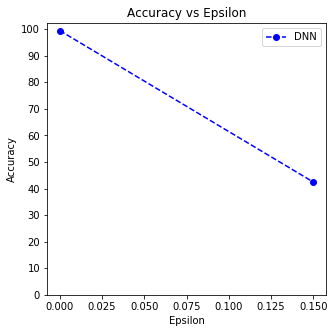

In [ ]:
plot_accuracy_vs_epsilon(model2, fgsm_adversarials2)

In [ ]:
def get_activations_big_data(model, dataset):
    reshaped_output_layer = []

    for i in neighbours_layers_indexes2: # 0,1,2-convolutions layer, 5-dense layer
        layer = model.layers[i]
        lay_act_arr = []
        chunk_size = 10000
        for i in range(0, 10000, chunk_size):
          lay_act = K.function([model.layers[0].input], [layer.output])([dataset[i:i+chunk_size]])[0]
          lay_act_arr = np.array(lay_act)
        for i in range(10000, len(dataset), chunk_size):
          lay_act = K.function([model.layers[0].input], [layer.output])([dataset[i:i+chunk_size]])[0]
          lay_act_arr = np.append(lay_act_arr, lay_act, axis=0)

        reshaped_output_layer.append(lay_act_arr.reshape(lay_act_arr.shape[0], lay_act_arr.shape[1]*lay_act_arr.shape[2]*lay_act_arr.shape[3]))
        # reshaped_output_layer.append(lay_act_arr)
    
    for layer in reshaped_output_layer:
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)

    return reshaped_output_layer

In [ ]:
activations_train2 = get_activations_big_data(model2, x_train)

try: 
  index_act2 = load_pickle('model2/experiment2/neighbours_index' + ind_neigh + '.pkl')
  print('loaded neighbours index from disc')
except FileNotFoundError:
  print('failed to load neighbours index from disc')
  index_act2 = {}
  for layer in range(knn_layers_count2):
    index_act2[layer] = index_layer(activations_train2[layer])
  # save_pickle(index_act2, 'model2/experiment2/neighbours_index_new.pkl')

failed to load neighbours index from disc


In [ ]:
# get activations of test set on each layer
activations2 = {}
for eps in epsilons:
  activations2[eps] = get_activations(model2, fgsm_adversarials2[eps], neighbours_layers_indexes2)

try:
  neighbors2 = load_pickle('model2/experiment2/neighbours' + find_neigh + '.pkl')
  print('loaded neighbours from disc')
except FileNotFoundError:
  print('failed to load neighbours from disc')
  neighbors2 = {}
  for layer in range(knn_layers_count2):
    neighbors2[layer] = {}
    for eps in epsilons:
      neighbors2[layer][eps] = find_neighbours(activations2[eps][layer], index_act2[layer], 0.1)
  # save_pickle(neighbors2, 'model2/experiment2/neighbours_new.pkl')

loaded neighbours from disc


In [ ]:
activations_calib2 = get_activations(model2, x_cal, neighbours_layers_indexes2)

neigbours_calib2 = {}
for layer in range(knn_layers_count2):
  neigbours_calib2[layer] = find_neighbours(activations_calib2[layer], index_act2[layer], 0.1)

nonconformity_calib2 = calibrate_nonconformity(neigbours_calib2, knn_layers_count2)

In [ ]:
p_values2, knn_predicted_labels2 = calculate_performance_parameters(neighbors2, nonconformity_calib2, knn_layers_count2)

[ 121.   44.    0.   47.  497.  486.  408.  612.  633. 6402.]
[0.70247934 0.90909091 0.         0.93617021 0.95171026 0.98353909
 0.99754902 0.99836601 1.         1.        ]


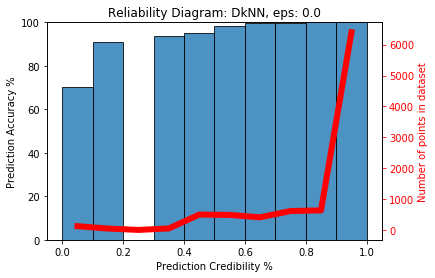

[1415.  612.    0.  515. 1429.  784.  461.  600.  567. 2867.]
[0.57314488 0.80555556 0.         0.80582524 0.81595521 0.91836735
 0.95010846 0.96833333 0.98589065 0.99616324]


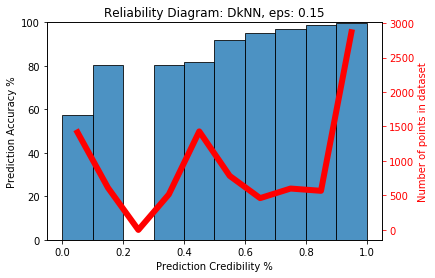

In [ ]:
# epss = 0.15
for epss in epsilons:
  plot_reliability('DkNN', epss, p_values2[epss], knn_predicted_labels2[epss])

[0.02564595453441143, 0.9947026968002319]
[0.09060890227556229, 0.9824864864349365]
[0.2629263401031494, 0.9496216177940369]
[0.6763343811035156, 0.8716756701469421]
[1.4843469858169556, 0.741729736328125]
[2.7148475646972656, 0.5805405378341675]
[4.227603435516357, 0.4243243336677551]
[7.3443403244018555, 0.2059459388256073]
[9.930551528930664, 0.10486486554145813]


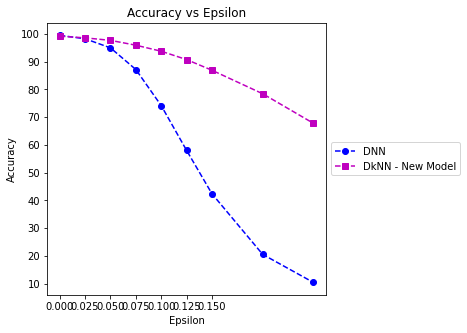

In [ ]:
# accuracies_plot_knn = accuracy_per_model(knn_predicted_labels)
# accuracies_plot_knn_annoy = accuracy_per_model(knn_predicted_labels_annoy)
# accuracies_plot_knn_lsh = accuracy_per_model(knn_predicted_labels_lsh)
accuracies_plot_knn_2 = accuracy_per_model(knn_predicted_labels2)

# accuracies_plot_knn = load_pickle('m1_knn.pkl')
# accuracies_plot_knn_lsh = load_pickle('m1_alsh.pkl')
# accuracies_plot_knn_annoy = load_pickle('m1_annoy.pkl')


plot_accuracy_vs_epsilon(model2, fgsm_adversarials2)
# plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='*', color='r', label = 'DkNN - PyNND')
# plt.plot(epsilons, accuracies_plot_knn_annoy, linestyle='--', marker='s', color='g', label = 'DkNN - Annoy')
# plt.plot(epsilons, accuracies_plot_knn_lsh, linestyle='--', marker='^', color='c', label = 'DkNN - Falconn')
plt.plot(epsilons, accuracies_plot_knn_2, linestyle='--', marker='s', color='m', label = 'DkNN - New Model')

lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('final_graph', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()